In [ ]:
### AUTHOR: RAJ MEHTA
### Visit my profile : https://rajmehta.info/
### Github: https://github.com/Raj-Mehta2012
### LinkedIn: https://www.linkedin.com/in/raj-kamlesh-mehta/

In [7]:
import pandas as pd
import boto3
import io 
import numpy as np
import pandas as pd
from scipy.optimize import minimize
# from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt

In [8]:
s3_bucket = "processed-meta-prices"
s3_client = boto3.client("s3")

# List all objects in the bucket (assuming only one .csv file)
try:
  bucket_objects = s3_client.list_objects_v2(Bucket=s3_bucket)["Contents"]
except Exception as e:
  print(f"Error listing objects in S3 bucket: {e}")

if not bucket_objects:
  print("No objects found in the bucket.")
  exit()  # Exit the script if no objects exist

# Assuming the first object is the CSV file
file_key = bucket_objects[0]["Key"]

# Download data from S3
try:
  response = s3_client.get_object(Bucket=s3_bucket, Key=file_key)
  data = response["Body"].read()
except Exception as e:
  print(f"Error downloading data from S3 for {file_key}: {e}")
  exit() 

#Load data into Dataframe
try:
  df = pd.read_csv(io.BytesIO(data)) 
  print(f"Loaded data from: {file_key}")
except Exception as e:
  print(f"Error loading data into DataFrame for {file_key}: {e}")
  exit()



Loaded data from: META_processed_data/part-00000-ea8b0691-99f2-47f5-8810-6951e1fa4342-c000.csv


/tmp/ipykernel_262/2929116865.py:60: OptimizeWarning: Unknown solver options: xtol
  results = minimize(kalman_filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 813.057014
         Iterations: 24
         Function evaluations: 215
         Gradient evaluations: 43
RMSE values is: 0.8426182285062582


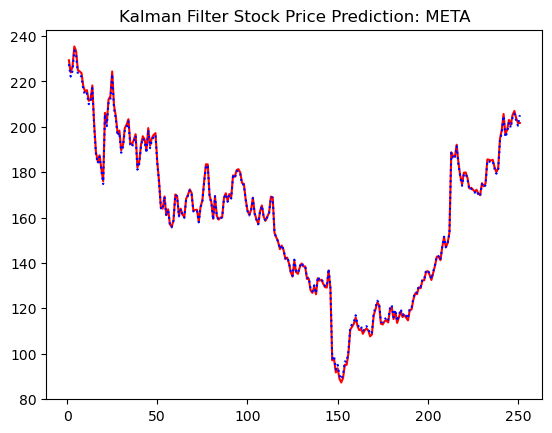

In [9]:
def kalman_filter(param,*args):
    # initialize params
    Z = param[0]
    T = param[1]
    H = param[2]
    Q = param[3]
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0]
    P_update[0] = np.var(Y)/4
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q
    Likelihood = 0
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H
        v[s]= Y[s-1]-Z*u_predict[s-1]
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
        Likelihood += (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]

    return Likelihood


def kalman_smoother(params, *args):
    # initialize params
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0]
    P_update[0] = np.var(Y)/4
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H
        v[s]=Y[s-1]-Z*u_predict[s-1]
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q

    u_smooth, P_smooth = {}, {}
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]
    for t in range(S-1, 0, -1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[s])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]

    # del u_update[-1]
    smooth_path = u_smooth
    return smooth_path

Y = df['Adj Close'].values
S = Y.shape[0]
param0 = np.array([0.85, 0.90, np.var(Y)/45, np.var(Y)/45])
results = minimize(kalman_filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})

# smoothe and visualize the estimated path
param_star = results.x
path = kalman_smoother(param_star, Y, S)
Y_kalmanFilter = np.hstack(list(path.values()))
Y_kalmanFilter = Y_kalmanFilter[::-1]

timevec = np.linspace(1,S,S)
plt.title('Kalman Filter Stock Price Prediction: META')
plt.plot(timevec, Y_kalmanFilter,'r',timevec, Y,'b:')

RMSE = np.sqrt(np.mean((Y_kalmanFilter - Y)**2))
print('RMSE values is:', RMSE)